Note: Your generator is NOT thread-safe.Keras requires a thread-safe generator when`use_multiprocessing=False, workers > 1`. But it's fine because GPU load is already high at 80%.
    
Second kernel:
1. use create_3Dspecgram() instead of get_specgram(),
2. use a deeper model architecture
2. improved the data generator for train & val (able to shuffle on train, Sequential on val; handle the last batch)

Improvement:
1. Spectrogram (nperseg, noverlap, reshape) <- Done!
2. Insert background noise randomly (data augmentation)
3. Develop a better data generator that is able to shuffle, handle the last batch, thread-safe <- Done!
4. Try different model architecture <- Done!

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pathlib import Path
import time
from scipy.io import wavfile
from scipy import signal

# df_train

In [2]:
def get_data(path):
    ''' Returns dataframe with columns: 'path', 'word'.'''
    datadir = Path(path)
    files = [(str(f), f.parts[-2]) for f in datadir.glob('**/*.wav')]
    df = pd.DataFrame(files, columns=['path', 'word'])
    
    return df

In [3]:
df_train = get_data('./input/train/')

print('df_train.shape:', df_train.shape)
df_train.head()

df_train.shape: (64727, 2)


,path,word
0,input\train\audio\bed\00176480_nohash_0.wav,bed
1,input\train\audio\bed\004ae714_nohash_0.wav,bed
2,input\train\audio\bed\004ae714_nohash_1.wav,bed
3,input\train\audio\bed\00f0204f_nohash_0.wav,bed
4,input\train\audio\bed\00f0204f_nohash_1.wav,bed


In [4]:
print(len(df_train['word'].unique()))
df_train['word'].unique()

31


array(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on',
       'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
       'two', 'up', 'wow', 'yes', 'zero', '_background_noise_'],
      dtype=object)

In [5]:
def prepare_data(df):
    '''Transform data into something more useful.'''
    train_words = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    words = df['word'].unique().tolist()
    silence = ['_background_noise_']
    unknown = [w for w in words if w not in silence + train_words]

    # there are only 6 silence files. Mark them as unknown too.
    df.loc[df['word'].isin(silence), 'word'] = 'unknown'
    df.loc[df['word'].isin(unknown), 'word'] = 'unknown'
    
    return df

In [6]:
df_train = prepare_data(df_train)

print('df_train.shape:', df_train.shape)
df_train.head()

df_train.shape: (64727, 2)


,path,word
0,input\train\audio\bed\00176480_nohash_0.wav,unknown
1,input\train\audio\bed\004ae714_nohash_0.wav,unknown
2,input\train\audio\bed\004ae714_nohash_1.wav,unknown
3,input\train\audio\bed\00f0204f_nohash_0.wav,unknown
4,input\train\audio\bed\00f0204f_nohash_1.wav,unknown


In [7]:
print(len(df_train['word'].unique()))
df_train['word'].unique()

11


array(['unknown', 'down', 'go', 'left', 'no', 'off', 'on', 'right',
       'stop', 'up', 'yes'], dtype=object)

# Create training and val set

In [8]:
from sklearn.preprocessing import LabelBinarizer

labelbinarizer = LabelBinarizer()
x = df_train['path']
y = labelbinarizer.fit_transform(df_train['word'])

In [9]:
print('y.shape:', y.shape)
y

y.shape: (64727, 11)


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [10]:
VALIDATION_SPLIT = 0.1

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                  test_size = VALIDATION_SPLIT,
                                                  stratify = y)  #distribute evenly according to y

print('x_train.shape', x_train.shape)
print('x_val.shape', x_val.shape)
print('y_train.shape', y_train.shape)
print('y_val.shape', y_val.shape)

x_train.shape (58254,)
x_val.shape (6473,)
y_train.shape (58254, 11)
y_val.shape (6473, 11)


# batch_generator

In [12]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [13]:
# log_specgram() testing
sample_rate, wav = wavfile.read(df_train['path'][0])
specgram = log_specgram(wav, sample_rate)[2]
specgram.shape

(99, 161)

In [14]:
def padding(wavs):
    '''input: [wavs]
       return: [wavs]'''
    
    data = [] 
    for wav in wavs:
        if len(wav) < sample_rate:
            d = np.pad(wav, (sample_rate - len(wav), 0), mode='constant')
        else:
            d = wav[0:sample_rate]
        data.append(d)
    
    return data

In [15]:
def create_3Dspecgram(wavs, sample_rate):
    ''' return 3-dimensional spectrograms
        channel_axis = 3
        freq_axis = 2
        time_axis = 1
    '''
    specgrams_3D = []
    for wav in wavs:
        specgram = signal.stft(wav, sample_rate,
                               nperseg = 400, noverlap = 240, nfft = 512, padded = False, boundary = None
                              )                      # specgram[2].shape: (129,126)(257,98)
        
        phase = np.angle(specgram[2]) / np.pi        #(257,98)
        amp = np.log1p(np.abs(specgram[2]))          #(257,98)
        
        specgram = np.stack([phase, amp], axis = 2)  #(257,98, 2)

        specgrams_3D.append(specgram)
    
    return specgrams_3D                              #(16, 257, 98, 2)

In [16]:
# create_3Dspecgram() testing

# get paths
paths = df_train['path'][:16]

# read wavs
wavs  = [wavfile.read(path)[1] for path in paths]

# padding
wavs = padding(wavs)

# create specgrams_3D
specgrams_3D = create_3Dspecgram(wavs, 16000)

print(np.array(specgrams_3D).shape)

(16, 257, 98, 2)


In [17]:
def train_generator(x, y, batch_size=32, sample_rate=16000):
    '''
    input: (x = paths, y = labels)
    return: (specgrams_3D (batch_size, 257, 98, 2), labels (batch_size, nr_classes))
    '''
    
    while True:
        
        # shuffle index
        shuffled_ids = np.random.choice(range(x.shape[0]),
                                size = x.shape[0],
                                replace=False)
        
        for start in range(0, len(shuffled_ids), batch_size):
            
            # to handle last batch
            end = min(start + batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
        
            paths = x[i_train_batch]
            labels = y[i_train_batch]

            # read the wav files
            wavs  = [wavfile.read(path)[1] for path in paths]

            # zero pad the shorter samples and cut off the long ones.
            wavs = padding(wavs)

            # create spectogram
            specgrams_3D = create_3Dspecgram(wavs, sample_rate)      #(16, 257, 98, 2)

            yield np.concatenate([specgrams_3D]), labels

In [18]:
def val_generator(x, y, batch_size=32, sample_rate=16000):
    '''
    input: (x = paths, y = labels)
    return: (specgrams_3D (batch_size, 257, 98, 2), labels (batch_size, nr_classes))
    '''
    
    while True:

        # Sequential index
        ids = list(range(x.shape[0]))
        for start in range(0, len(ids), batch_size):
            
            # to handle last batch
            end = min(start + batch_size, len(ids))
            i_val_batch = ids[start:end]

            paths = x[i_val_batch]
            labels = y[i_val_batch]

            # read the wav files
            wavs  = [wavfile.read(path)[1] for path in paths]

            # zero pad the shorter samples and cut off the long ones.
            wavs = padding(wavs)

            # create spectogram
            specgrams_3D = create_3Dspecgram(wavs, sample_rate)      #(16, 129, 126, 2)

            yield np.concatenate([specgrams_3D]), labels

In [19]:
BATCH_SIZE = 16

In [20]:
train_datagen = train_generator(x_train.values, y_train, batch_size=BATCH_SIZE)
val_datagen = val_generator(x_val.values, y_val, batch_size=BATCH_SIZE)

In [21]:
# train_datagen testing
i=1
for x_batch, y_batch in train_datagen:
    if i > 3:
        break
    print(x_batch.shape)
    print(y_batch.shape)
    i+=1

(16, 257, 98, 2)
(16, 11)
(16, 257, 98, 2)
(16, 11)
(16, 257, 98, 2)
(16, 11)


In [22]:
# val_datagen testing
i=1
for x_batch, y_batch in val_datagen:
    if i > 3:
        break
    print(x_batch.shape)
    print(y_batch.shape)
    i+=1

(16, 257, 98, 2)
(16, 11)
(16, 257, 98, 2)
(16, 11)
(16, 257, 98, 2)
(16, 11)


# Model

In [23]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dense, Dropout, Reshape
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.layers import ELU
from keras.layers import CuDNNGRU
from keras.optimizers import SGD

from keras.optimizers import Adam

Using TensorFlow backend.


In [24]:
# Metric: F1

def f1(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [25]:
# GRADED FUNCTION: model

def create_model(input_shape):
    
    channel_axis = 3
    freq_axis = 2
    time_axis = 1

    melgram_input = Input(shape=input_shape)
    #x = ZeroPadding2D(padding=(0, 37))(melgram_input)
    x = BatchNormalization(axis=freq_axis, name='bn_0_freq')(melgram_input)

    # Conv block 1
    x_1 = Conv2D(64, (3, 3), name="conv1", padding="same")(x)
    x_1 = BatchNormalization(axis=channel_axis, name="bn1")(x_1)
    x_1 = ELU()(x_1)
    x_1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(x_1)
    x_1 = Dropout(0.1, name='dropout1')(x_1)

    # Conv block 2
    x_2 = Conv2D(128, (3, 3), name="conv2", padding="same")(x_1)
    x_2 = BatchNormalization(axis=channel_axis, name="bn2")(x_2)
    x_2 = ELU()(x_2)
    x_2 = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2')(x_2)
    x_2 = Dropout(0.1, name='dropout2')(x_2)

    # Conv block 3
    x_3 = Conv2D(128, (3, 3), name="conv3", padding="same")(x_2)
    x_3 = BatchNormalization(axis=channel_axis, name="bn3")(x_3)
    x_3 = ELU()(x_3)
    x_3 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool3')(x_3)
    x_3 = Dropout(0.1, name='dropout3')(x_3)

    # Conv block 4
    x_4 = Conv2D(128, (3, 3), name="conv4", padding="same")(x_3)
    x_4 = BatchNormalization(axis=channel_axis, name="bn4")(x_4)
    x_4 = ELU()(x_4)
    x_4 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool4')(x_4)
    x_4 = Dropout(0.1, name='dropout4')(x_4)

    # reshaping
    x = Reshape((2, 128))(x_4)

    # GRU block 1, 2, output
    x_gru = CuDNNGRU(32, return_sequences=True, name='gru1')(x)
    x_gru = CuDNNGRU(32, return_sequences=False, name='gru2')(x_gru)
    x_gru = Dropout(0.3)(x_gru)
    output = Dense(11, activation='sigmoid', name='output')(x_gru)

    model = Model(inputs = melgram_input, outputs = output)
    
    model.summary()
    
    return model  

In [26]:
INPUT_SHAPE = (257, 98, 2)

In [27]:
%%time

keras.backend.clear_session()

# Create model
model = create_model(input_shape = INPUT_SHAPE)

# Load weights
model.load_weights('./model/speech_valloss_0.1027.h5')

# Compile model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(lr=1e-03),
    metrics = ['acc', f1])








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 257, 98, 2)        0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 257, 98, 2)        392       
_________________________________________________________________
conv1 (Conv2D)               (None, 257, 98, 64)       1216      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 257, 98, 64)       256       
_________________________________________________________________
elu_1 (ELU)                  (None, 257, 98, 64)       0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 49, 64)       0         
____________________

In [28]:
# Callbacks

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

callbacks = [
             EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, cooldown=1, min_lr=1e-6),
             ModelCheckpoint(filepath='./model/speech_valloss.h5', monitor='val_loss',
                             save_best_only=True, save_weights_only=False),
            ]

In [29]:
EPOCHS = 20
train_steps = int(np.ceil(x_train.shape[0]/BATCH_SIZE))
val_steps = int(np.ceil(x_val.shape[0]/BATCH_SIZE))

print('train_steps:', train_steps)
print('val_steps:', val_steps)

train_steps: 3641
val_steps: 405


In [30]:
# Reset data generator

train_datagen = train_generator(x_train.values, y_train, batch_size=BATCH_SIZE)
val_datagen = val_generator(x_val.values, y_val, batch_size=BATCH_SIZE)

In [30]:
%%time
# Train the model

history = model.fit_generator(
                train_datagen,
                steps_per_epoch = train_steps,
                epochs = EPOCHS,
                validation_data = val_datagen,
                validation_steps = val_steps,
                callbacks = callbacks,
                #workers=3,  #generator is not thread-safe
                #max_queue_size=10,
                )

Epoch 1/20
2143/3641 [================>.............] - ETA: 1:41 - loss: 1.2300 - acc: 0.6516 - f1: 0.16

D:\Anaconda3\envs\tensorflow\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


3641/3641 [==============================] - 260s 71ms/step - loss: 1.0582 - acc: 0.6799 - f1: 0.2028 - val_loss: 0.6041 - val_acc: 0.7870 - val_f1: 0.2547
Epoch 2/20
3641/3641 [==============================] - 257s 70ms/step - loss: 0.5583 - acc: 0.8214 - f1: 0.2221 - val_loss: 0.3673 - val_acc: 0.8871 - val_f1: 0.2131
Epoch 3/20
3641/3641 [==============================] - 257s 70ms/step - loss: 0.3866 - acc: 0.8878 - f1: 0.1839 - val_loss: 0.2162 - val_acc: 0.9367 - val_f1: 0.2148
Epoch 4/20
3641/3641 [==============================] - 258s 71ms/step - loss: 0.2963 - acc: 0.9157 - f1: 0.1815 - val_loss: 0.2417 - val_acc: 0.9291 - val_f1: 0.1721
Epoch 5/20
3641/3641 [==============================] - 258s 71ms/step - loss: 0.2498 - acc: 0.9290 - f1: 0.1758 - val_loss: 0.1824 - val_acc: 0.9448 - val_f1: 0.2141
Epoch 6/20
3641/3641 [==============================] - 258s 71ms/step - loss: 0.2132 - acc: 0.9396 - f1: 0.1781 - val_loss: 0.1497 - val_acc: 0.9546 - val_f1: 0.1844
Epoch 7/2

In [28]:
# Save model
# model.save('./model/speech_valloss_.h5')

In [31]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'val_f1', 'loss', 'acc', 'f1', 'lr'])


# Model Evaluation

## 1) Plot learning rate, loss, acc

In [32]:
def show_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(15,5))
    ax[0].set_title('learning rate')
    ax[0].plot(history.epoch, history.history["lr"], label="lr")

    ax[1].set_title('loss')
    ax[1].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[1].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    
    ax[3].set_title('f1')
    ax[3].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[3].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

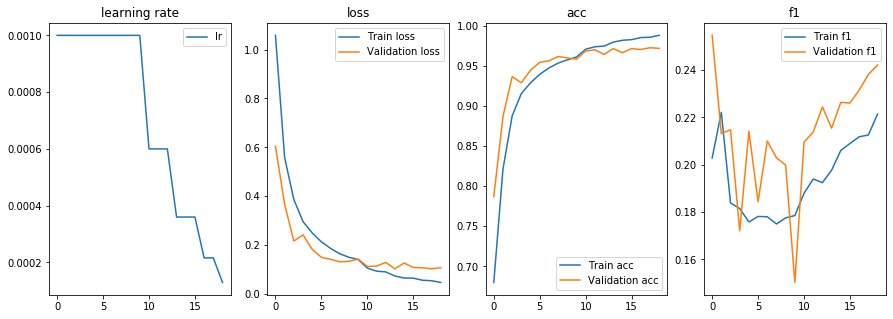

In [33]:
show_history(history)

## 2) Loss, acc, f1

In [31]:
# Reset data generator

val_datagen = val_generator(x_val.values, y_val, batch_size=BATCH_SIZE)

In [32]:
%%time

# score = model.evaluate(x_val, y_val)
score = model.evaluate_generator(val_datagen, 
                                 steps = val_steps
                                )
print("loss:", score[0])
print("metric (acc):", score[1])
print("metric (f1):", score[2])

D:\Anaconda3\envs\tensorflow\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


loss: 0.035687975325185285
metric (acc): 0.9898038004108767
metric (f1): 0.2232470864580926
Wall time: 1min 21s


## 3) Confusion Matrix

There is a problem: val_datagen has shuffle index. So the confusion matrix give wrong result.

Solution: make a better data generator

In [33]:
# Reset data generator

val_datagen = val_generator(x_val.values, y_val, batch_size=BATCH_SIZE)

In [34]:
%%time

# y_val_pred = model.predict_classes(x_val)
y_val_pred_prob = model.predict_generator(val_datagen, 
                                          steps = val_steps
                                         )

Wall time: 14.8 s


In [35]:
print('y_val_pred_prob.shape:', y_val_pred_prob.shape)
y_val_pred_prob

y_val_pred_prob.shape: (6473, 11)


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.8456578e-04,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.0772219e-04,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.4849176e-04,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.8978119e-04,
        0.0000000e+00, 0.0000000e+00],
       [5.3644180e-07, 2.4139881e-06, 5.9604645e-05, ..., 9.8231435e-04,
        8.6426735e-07, 9.5367432e-07],
       [1.1026859e-05, 4.7177076e-05, 1.8268824e-05, ..., 3.9475905e-03,
        7.6797160e-06, 5.1556934e-05]], dtype=float32)

In [36]:
y_val_pred_prob.max(axis=1,keepdims=1)

array([[1.8456578e-04],
       [2.0772219e-04],
       [2.4849176e-04],
       ...,
       [1.8978119e-04],
       [7.4986827e-01],
       [3.9475905e-03]], dtype=float32)

In [37]:
y_val_pred = (y_val_pred_prob == y_val_pred_prob.max(axis=1,keepdims=1)).astype(int)
y_val_pred

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [38]:
import itertools
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred, labels):
    instcount = y_true.shape[0]
    n_classes = len(labels)
    fp = ((y_true - y_pred) < 0).sum(axis = 0)
    fn = ((y_true - y_pred) > 0).sum(axis = 0)
    tp = (y_true*y_pred).sum(axis = 0)
    tn = ((y_true==0)*(y_pred==0)).sum(axis = 0)
    mtx = np.vstack([tp/(tp + fn), fn/(tp + fn), tn/(tn + fp), fp/(tn + fp)]).T
    plt.figure(num=None, figsize=(5, 15), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(mtx, interpolation='nearest',cmap='Blues')
    plt.title("Confusion matrix")
    tick_marks = np.arange(n_classes)
    plt.xticks(np.arange(4), ['1 - 1','1 - 0','0 - 0','0 - 1'])
    plt.yticks(tick_marks, labels)
    for i, j in itertools.product(range(n_classes), range(4)):
        plt.text(j, i, round(mtx[i][j],2), horizontalalignment="center")

    plt.ylabel('labels')
    plt.xlabel('True-Predicted')
    plt.show()

In [39]:
labels = df_train['word'].unique().tolist()
labels

['unknown',
 'down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'stop',
 'up',
 'yes']

In [40]:
y_val.shape

(6473, 11)

In [41]:
y_val_pred.shape

(6473, 11)

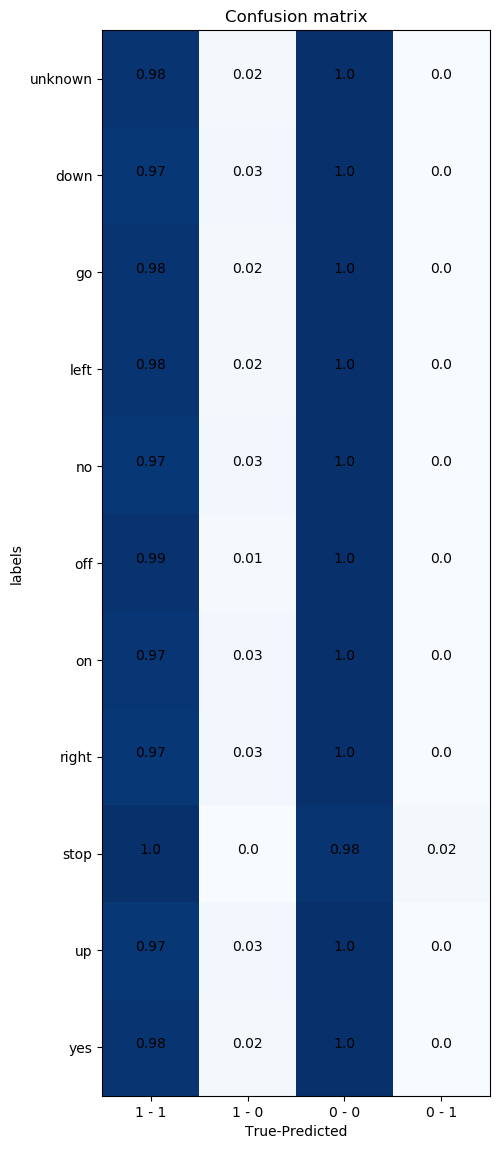

In [42]:
confusion_matrix(y_val,
                 y_val_pred,
                 labels)

# 4) Miss-Classification table

In [43]:
def miss_classification(y_true, y_pred, classes, percent=False, multi_label=True):
    '''
    Params:
        y_true, y_pred : binary numpy array
        classes : list of names classes
        percent : display persent of miss classification
        multi_label : target can have multy labels
    '''

    n_classes = len(classes)
    fp = ((y_true - y_pred) < 0).astype('int')
    fn = ((y_true - y_pred) > 0).astype('int')
    mtc = (fn.T @ fp)
    if multi_label:
        mtc = np.hstack([mtc, (fp.sum(axis = 0) - mtc.sum(axis = 0)).clip(0)[:,None]])
        classes.append('As extra class')
    if percent:
        mtc = (mtc / mtc.sum(axis = 1)[:,None])
        mtc = np.nan_to_num(mtc).clip(0,1) * 100
        
    plt.figure(num=None, figsize=(10.5, 10.5), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(mtc, interpolation='nearest',cmap='Blues')
    plt.title("Miss-Classification table")

    plt.xticks(np.arange(mtc.shape[1]), classes, rotation=90)
    plt.yticks(np.arange(mtc.shape[0]), classes, rotation=0)
    
    for i in range(mtc.shape[0]):
        for j in range(mtc.shape[1]):
            plt.text(j, i, int(mtc[i][j]), horizontalalignment="center")
    plt.ylabel('True labels')
    plt.xlabel('Predicted Miss labeled')
    plt.show()

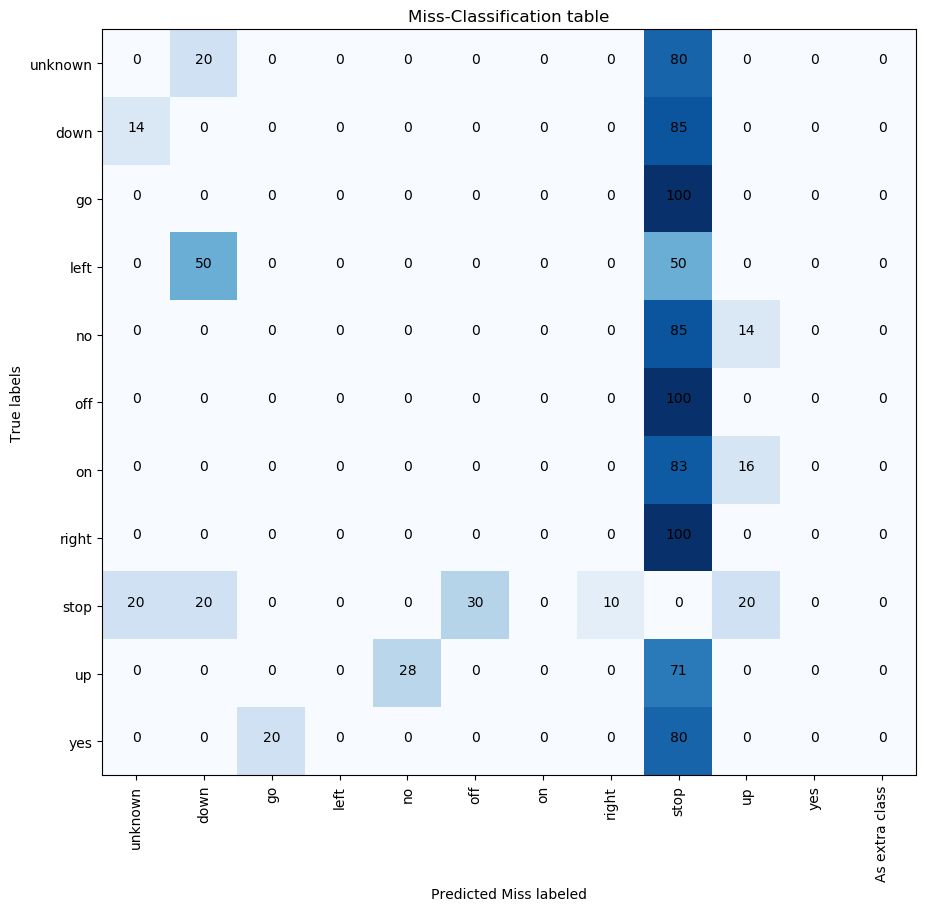

In [44]:
miss_classification(y_val,
                    y_val_pred,
                    labels,
                    percent=True)

# Prediction

In [45]:
df_test = get_data('./input/test/')

print('df_test.shape:', df_test.shape)
df_test.head()

df_test.shape: (158538, 2)


,path,word
0,input\test\audio\clip_000044442.wav,audio
1,input\test\audio\clip_0000adecb.wav,audio
2,input\test\audio\clip_0000d4322.wav,audio
3,input\test\audio\clip_0000fb6fe.wav,audio
4,input\test\audio\clip_0001d1559.wav,audio


In [46]:
df_test['word'] = 'unknown'

print('df_test.shape:', df_test.shape)
df_test.head()

df_test.shape: (158538, 2)


,path,word
0,input\test\audio\clip_000044442.wav,unknown
1,input\test\audio\clip_0000adecb.wav,unknown
2,input\test\audio\clip_0000d4322.wav,unknown
3,input\test\audio\clip_0000fb6fe.wav,unknown
4,input\test\audio\clip_0001d1559.wav,unknown


In [47]:
def test_generator(x, batch_size=32, sample_rate=16000):
    '''
    input: (x = paths)
    return: (specgrams_3D (batch_size, 257, 98, 2))
    '''
    
    while True:

        # Sequential index
        ids = list(range(x.shape[0]))
        for start in range(0, len(ids), batch_size):
            
            # to handle last batch
            end = min(start + batch_size, len(ids))
            i_val_batch = ids[start:end]

            paths = x[i_val_batch]

            # read the wav files
            wavs  = [wavfile.read(path)[1] for path in paths]

            # zero pad the shorter samples and cut off the long ones.
            wavs = padding(wavs)

            # create spectogram
            specgrams_3D = create_3Dspecgram(wavs, sample_rate)      #(16, 129, 126, 2)

            yield np.concatenate([specgrams_3D])

In [48]:
test_datagen = test_generator(df_test['path'].values, batch_size=BATCH_SIZE)

In [49]:
# test_datagen testing
i=1
for x_batch in test_datagen:
    if i > 3:
        break
    print(x_batch.shape)
    i+=1

(16, 257, 98, 2)
(16, 257, 98, 2)
(16, 257, 98, 2)


In [50]:
test_steps = int(np.ceil(df_test.shape[0]/BATCH_SIZE))
print('test_steps:', test_steps)

test_steps: 9909


In [51]:
# Reset data generator

test_datagen = test_generator(df_test['path'].values, batch_size=BATCH_SIZE)

In [52]:
%%time

predictions_prob = model.predict_generator(test_datagen, 
                                          steps = test_steps
                                         )

Wall time: 9min 51s


In [54]:
print('predictions_prob.shape', predictions_prob.shape)
predictions_prob

predictions_prob.shape (158538, 11)


array([[2.8550625e-05, 6.1124563e-05, 1.1116266e-05, ..., 4.5540929e-04,
        8.9406967e-08, 1.7136335e-05],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.1627545e-04,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.9802322e-08, 0.0000000e+00, ..., 3.9938092e-04,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [2.1755695e-06, 2.2351742e-06, 1.1622906e-06, ..., 4.5093894e-04,
        4.8875809e-05, 9.2387199e-07],
       [4.0910244e-03, 8.0054104e-03, 3.7577748e-03, ..., 4.0525407e-02,
        9.2433691e-03, 2.4082959e-03],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.2482872e-04,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [55]:
predictions_prob.max(axis=1,keepdims=1)

array([[2.7965432e-01],
       [2.1627545e-04],
       [3.9938092e-04],
       ...,
       [8.8002771e-02],
       [4.0525407e-02],
       [2.2482872e-04]], dtype=float32)

In [56]:
predictions = (predictions_prob == predictions_prob.max(axis=1,keepdims=1)).astype(int)
predictions

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [57]:
predictions_label = labelbinarizer.inverse_transform(predictions)
print('predictions_label.shape:', predictions_label.shape)
predictions_label

predictions_label.shape: (158538,)


array(['no', 'unknown', 'unknown', ..., 'stop', 'unknown', 'unknown'],
      dtype='<U7')

In [58]:
df_test['labels'] = predictions_label

In [59]:
df_test['path'] = df_test['path'].apply(lambda x: str(x).split("\\")[-1])

In [60]:
df_test.head(100)

,path,word,labels
0,clip_000044442.wav,unknown,no
1,clip_0000adecb.wav,unknown,unknown
2,clip_0000d4322.wav,unknown,unknown
3,clip_0000fb6fe.wav,unknown,unknown
4,clip_0001d1559.wav,unknown,unknown
5,clip_0002256ed.wav,unknown,unknown
6,clip_0002a4a1f.wav,unknown,unknown
7,clip_0002d9b83.wav,unknown,unknown
8,clip_000373a5b.wav,unknown,go
9,clip_0003c7122.wav,unknown,unknown


In [61]:
submission = pd.DataFrame({'fname': df_test['path'], 'label': df_test['labels']})
submission.head(10)

,fname,label
0,clip_000044442.wav,no
1,clip_0000adecb.wav,unknown
2,clip_0000d4322.wav,unknown
3,clip_0000fb6fe.wav,unknown
4,clip_0001d1559.wav,unknown
5,clip_0002256ed.wav,unknown
6,clip_0002a4a1f.wav,unknown
7,clip_0002d9b83.wav,unknown
8,clip_000373a5b.wav,go
9,clip_0003c7122.wav,unknown


In [62]:
submission.to_csv('./output/submission.csv', index=False)